In [1]:
import calendar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

## Data loading and preprocessing

In [2]:
data_folder = Path("data")
df = pd.read_csv(data_folder / "electricity.csv", parse_dates=["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

In [3]:
df.head()

,datetime,production_nuclear,production_thermal,production_renewable,production_heat_power,production_hydro,production_pumped_hydro,consumption_total
0,2014-01-01 01:00:00,10728,2016,50,8892,1809,0,20586
1,2014-01-01 02:00:00,10606,2014,49,8885,863,0,19665
2,2014-01-01 03:00:00,10515,2022,54,8731,355,0,19107
3,2014-01-01 04:00:00,10475,2014,42,8369,185,0,18453
4,2014-01-01 05:00:00,10427,2009,49,8355,274,0,18072


In [4]:
prod_cols = [col for col in df.columns if col.startswith("production")]
df["production_total"] = df[prod_cols].sum(axis=1)
total_cols = ["consumption_total", "production_total"]

df["month"] = df.datetime.apply(lambda dt: dt.month)
df["monthday"] = df.datetime.apply(lambda dt: dt.day)
df["weekday"] = df.datetime.apply(lambda dt: dt.weekday())
df["dayhour"] = df.datetime.apply(lambda dt: dt.hour)

## Initial questions

**General**
- When the beginning/end of the provided data is? Are there any missed dates?
- What is records frequrency?


**Production sources related**
- Does electricity production dominate over consumption amount?
- Why some sources have zero values? When such zero values appear?
- Which power source produces the largest amount of electricity in Ukraine? Is it changing for a year?


**Consumption related**
- Does the data have any periodicity?
- In which month power consumption reaches its maximum? 


## EDA

In [5]:
print(f"Init date: {df.datetime.min().isoformat()}")
print(f"Last date: {df.datetime.max().isoformat()}")

Init date: 2014-01-01T01:00:00
Last date: 2020-12-09T23:00:00


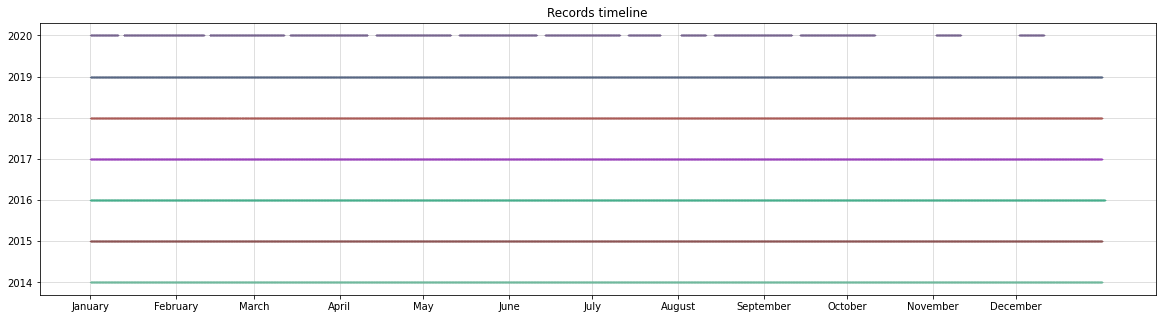

In [6]:
np.random.seed(42)
year_range = list(range(2014, 2021))
year_color = {y: np.random.rand(3) * 0.5 + 0.25 for y in year_range}

x_vals = df.datetime.apply(lambda v: datetime.utcfromtimestamp((v.timestamp() \
                                                - pd.to_datetime(v.year, format="%Y").timestamp())))

plt.figure(figsize=(20, 5))
for year in year_range:
    year_vals = x_vals[df.datetime.apply(lambda v: v.year == year)]
    plt.plot(year_vals, [year] * len(year_vals), ".", markersize=0.7, c=year_color[year])

x_ticks = pd.to_datetime(["1970/" + str(v).zfill(2) for v in range(1, 13)], format="%Y/%m")
x_labels = np.apply_along_axis(lambda v: pd.to_datetime(v).month_name(), 0, x_ticks)
plt.xticks(ticks=x_ticks, labels=x_labels)

plt.title("Records timeline")
plt.grid(alpha=0.5)

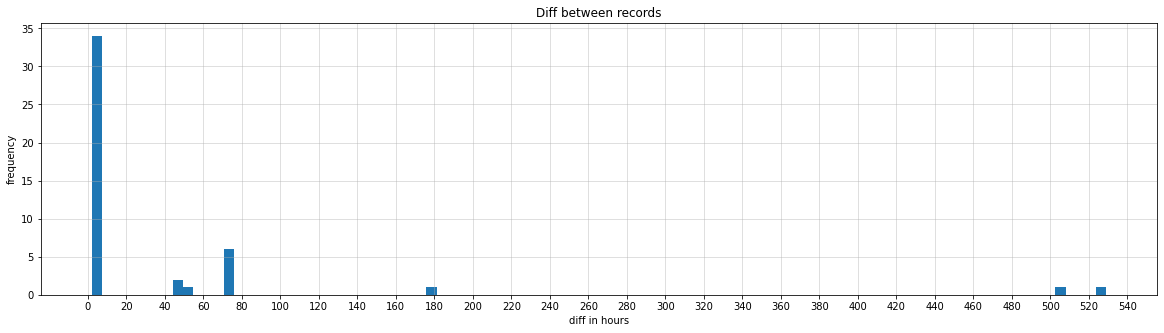

In [7]:
diff = df.datetime.sort_values().diff()[1:] / np.timedelta64(1, 'h')
diff = diff[diff > 1.0]

plt.figure(figsize=(20, 5))
plt.hist(diff, bins=100)

plt.xlabel("diff in hours")
plt.xticks(range(0, 560, 20))

plt.ylabel("frequency")

plt.title("Diff between records")
plt.grid(alpha=0.5)

Some words about missing dates
The first plot shows missing dates in the dataset. 
Every line represents a continuous sequence of records for every year. 

Gaps between lines represent missing values. As we can see there are not missing dates till 2020 year. 

In 2020 there are a lot of gaps, especially by the end of the year (part of the data was not even existed by the time of data fetching).

The second graph represents a distribution of gap durations in hours (the difference between neighbor records).
There are some gaps longer than a week but the most of gaps are less than 5 hours.

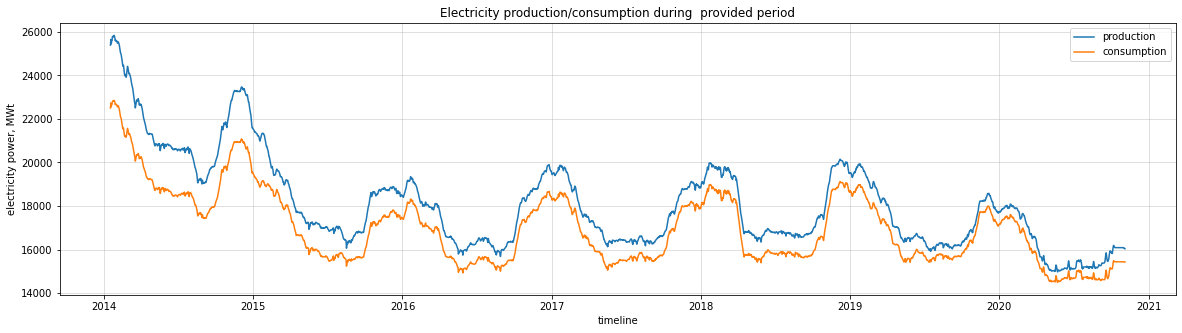

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(df.datetime, df.production_total.rolling(24*30, center=True).mean(), label="production")
plt.plot(df.datetime, df.consumption_total.rolling(24*30, center=True).mean(), label="consumption")

plt.legend()
plt.ylabel("electricity power, MWt")
plt.xlabel("timeline")
plt.title("Electricity production/consumption during  provided period")
plt.grid(alpha=0.5)

Production and power consumption are highly correlated. The amount of consumed power is a little bit smaller than the produced amount (where is a surplus?).

There is a trend in decreasing overall power consumption/production. It could be possibly related to the difficult political situation since 2014 in Ukraine and the lack of information from temporarily occupied territories.

A small consumption decreasing in 2020 in comparison to the previous year could be caused by the coronavirus pandemic.

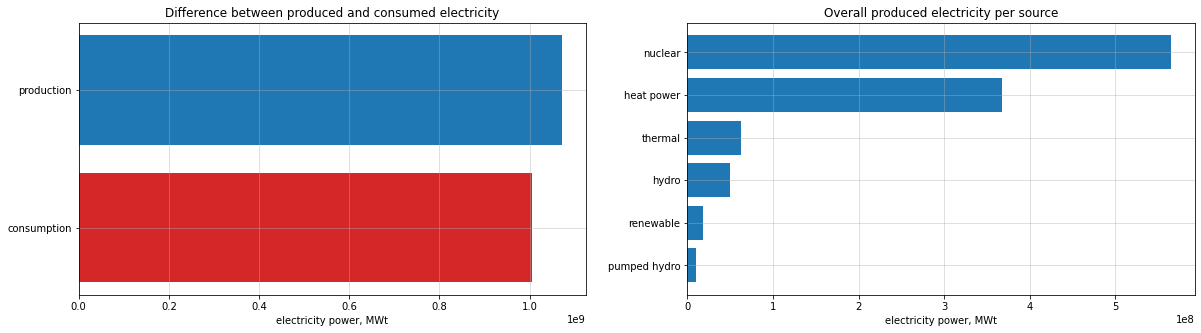

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.barh(y=[col.split("_")[0] for col in total_cols], width=df.sum()[total_cols], color=["C3", "C0"])
plt.xlabel("electricity power, MWt")
plt.title("Difference between produced and consumed electricity")
plt.grid(alpha=0.5)

plt.subplot(1, 2, 2)
sum_prod = df.sum()[prod_cols]
sum_prod = sum_prod.sort_values(ascending=True)
y_values = [" ".join(s.split("_")[1:]) for s in sum_prod.index]
plt.barh(y=y_values, width=sum_prod)
plt.xlabel("electricity power, MWt")
plt.title("Overall produced electricity per source")
plt.grid(alpha=0.5)


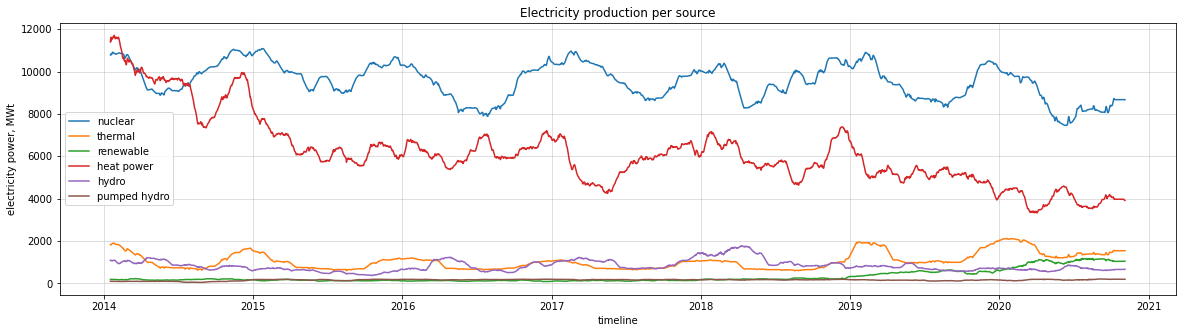

In [10]:
plt.figure(figsize=(20, 5))
for col in prod_cols:
    plt.plot(df.datetime, df[[col]].rolling(24*30, center=True).mean(), label=" ".join(col.split("_")[1:]))
    
plt.legend()
plt.ylabel("electricity power, MWt")
plt.xlabel("timeline")
plt.title("Electricity production per source")
plt.grid(alpha=0.5)

The amount of produced heat power is decreased during the past years. Nuclear power is almost at the same level during the observed period of time. It is a major power source in Ukraine now.

There are several unclear moments for me:
- what is the difference between hydro and pumped hydro, heat, and thermal sources? why they are not counted as a single source?
- why hydro is not counted in renewable power sources?

Some sources have such an insignificant part in the overall listing that they even became zero at some points (pumped hydro and renewable). 

It is important to notice that despite not a main part of overall produced power, renewable sources expanding during the last two years.

Also, two orange peaks (thermal power source) seem interesting to me. Maybe it is just related to the beginning of the calendar year but it is better to check some additional factors.

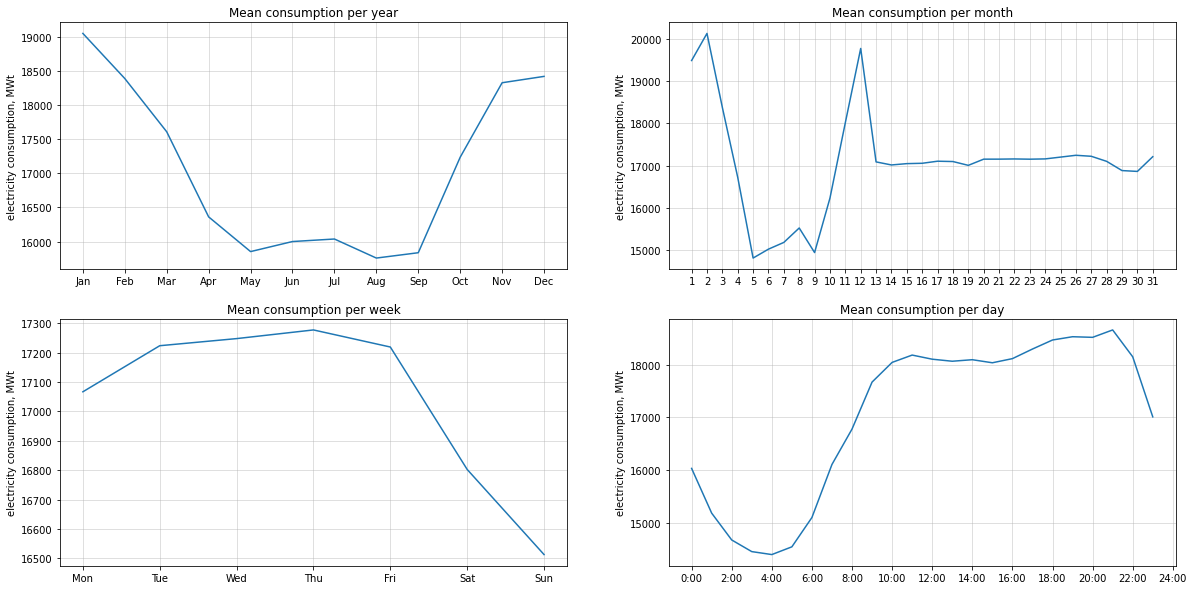

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(df.groupby(df.month).mean().consumption_total)
plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i][:3] for i in range(1, 13)])
plt.ylabel("electricity consumption, MWt")
plt.title("Mean consumption per year")
plt.grid(alpha=0.5)


plt.subplot(2, 2, 2)
plt.plot(df.groupby(df.monthday).mean().consumption_total)
plt.xticks(ticks=range(1, 32), labels=range(1, 32))
plt.ylabel("electricity consumption, MWt")
plt.title("Mean consumption per month")
plt.grid(alpha=0.5)

plt.subplot(2, 2, 3)
plt.plot(df.groupby(df.weekday).mean().consumption_total)
plt.xticks(ticks=range(0, 7), labels=[calendar.day_name[i][:3] for i in range(0, 7)])
plt.ylabel("electricity consumption, MWt")
plt.title("Mean consumption per week")
plt.grid(alpha=0.5)

plt.subplot(2, 2, 4)
plt.plot(df.groupby(df.dayhour).mean().consumption_total)
plt.xticks(ticks=range(0, 25, 2), labels=[f"{i}:00" for i in range(0, 25, 2)])
plt.ylabel("electricity consumption, MWt")
plt.title("Mean consumption per day")
plt.grid(alpha=0.5)

On those graphs, we explore how electricity consumption is changing during some periods of time on different scales (year, month, week, and day).

- the power consumption is much higher in the winter period of time and it is on its low during summer which is quite obvious.
- there is a strange consumption minimum during the first week of the month. I don't have any explanation for that yet.
- electricity consumption decreases during weekends, maybe because people use to spent more time outside ;)
- the last one is a graph describing how electricity consumption changes per day. 
It is on its low during the night cause ordinary people sleep at that time. The maximum point is the evening.